<a href="https://colab.research.google.com/github/AoShuang92/seep_segmentation/blob/main/seep_detection_LinkNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##CGG - Oil Seep Detection Exercise

The objective of this assignment is to segment the non-seep and seep regions. The images are 256x256 pixels, in total 790 images in the dataset.

Download dataset url: https://drive.google.com/file/d/1DnelhBUHCkCD_PFNyHuMk7hZYwrcZCyh/view?usp=sharing

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

id = '1DnelhBUHCkCD_PFNyHuMk7hZYwrcZCyh'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('seep_detection.tar.gz')
!tar -xvzf seep_detection.tar.gz

seep_detection/
seep_detection/train_masks_256/
seep_detection/train_masks_256/041869.000003.tif
seep_detection/train_masks_256/041869.000024.tif
seep_detection/train_masks_256/041869.000026.tif
seep_detection/train_masks_256/041869.000007.tif
seep_detection/train_masks_256/041869.000004.tif
seep_detection/train_masks_256/041869.000005.tif
seep_detection/train_masks_256/041869.000023.tif
seep_detection/train_masks_256/041869.000043.tif
seep_detection/train_masks_256/041869.000045.tif
seep_detection/train_masks_256/041869.000044.tif
seep_detection/train_masks_256/041869.000046.tif
seep_detection/train_masks_256/041869.000062.tif
seep_detection/train_masks_256/041869.000065.tif
seep_detection/train_masks_256/041869.000102.tif
seep_detection/train_masks_256/041869.000063.tif
seep_detection/train_masks_256/041869.000064.tif
seep_detection/train_masks_256/041869.000082.tif
seep_detection/train_masks_256/041869.000101.tif
seep_detection/train_masks_256/041869.000083.tif
seep_detection/train_

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch import optim
import torch.nn.functional as F
from glob import glob
import csv
import random
import re
import os
from PIL import Image
import numpy as np
import sklearn.metrics

def seed_everything(seed=27):
  
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  np.random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False



Model Architecture: U-Net

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision.models import resnet


class BasicBlock(nn.Module):

    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, groups=1, bias=False):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size, stride, padding, groups=groups, bias=bias)
        self.bn1 = nn.BatchNorm2d(out_planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size, 1, padding, groups=groups, bias=bias)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.downsample = None
        if stride > 1:
            self.downsample = nn.Sequential(nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False),
                            nn.BatchNorm2d(out_planes),)

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Encoder(nn.Module):

    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, groups=1, bias=False):
        super(Encoder, self).__init__()
        self.block1 = BasicBlock(in_planes, out_planes, kernel_size, stride, padding, groups, bias)
        self.block2 = BasicBlock(out_planes, out_planes, kernel_size, 1, padding, groups, bias)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)

        return x


class Decoder(nn.Module):

    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, output_padding=0, groups=1, bias=False):
        # TODO bias=True
        super(Decoder, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_planes, in_planes//4, 1, 1, 0, bias=bias),
                                nn.BatchNorm2d(in_planes//4),
                                nn.ReLU(inplace=True),)
        self.tp_conv = nn.Sequential(nn.ConvTranspose2d(in_planes//4, in_planes//4, kernel_size, stride, padding, output_padding, bias=bias),
                                nn.BatchNorm2d(in_planes//4),
                                nn.ReLU(inplace=True),)
        self.conv2 = nn.Sequential(nn.Conv2d(in_planes//4, out_planes, 1, 1, 0, bias=bias),
                                nn.BatchNorm2d(out_planes),
                                nn.ReLU(inplace=True),)

    def forward(self, x):
        x = self.conv1(x)
        x = self.tp_conv(x)
        x = self.conv2(x)

        return x


class LinkNet(nn.Module):
    """
    Generate Model Architecture
    """

    def __init__(self, n_classes=8):
        """
        Model initialization
        :param x_n: number of input neurons
        :type x_n: int
        """
        super(LinkNet, self).__init__()

        base = resnet.resnet18(pretrained=True)

        self.in_block = nn.Sequential(
            base.conv1,
            base.bn1,
            base.relu,
            base.maxpool
        )

        self.encoder1 = base.layer1
        self.encoder2 = base.layer2
        self.encoder3 = base.layer3
        self.encoder4 = base.layer4

        self.decoder1 = Decoder(64, 64, 3, 1, 1, 0)
        self.decoder2 = Decoder(128, 64, 3, 2, 1, 1)
        self.decoder3 = Decoder(256, 128, 3, 2, 1, 1)
        self.decoder4 = Decoder(512, 256, 3, 2, 1, 1)

        # Classifier
        self.tp_conv1 = nn.Sequential(nn.ConvTranspose2d(64, 32, 3, 2, 1, 1),
                                      nn.BatchNorm2d(32),
                                      nn.ReLU(inplace=True),)
        self.conv2 = nn.Sequential(nn.Conv2d(32, 32, 3, 1, 1),
                                nn.BatchNorm2d(32),
                                nn.ReLU(inplace=True),)
        self.tp_conv2 = nn.ConvTranspose2d(32, n_classes, 2, 2, 0)
        self.lsm = nn.LogSoftmax(dim=1)


    def forward(self, x):
        # Initial block
        x = self.in_block(x)

        # Encoder blocks
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)

        # Decoder blocks
        #d4 = e3 + self.decoder4(e4)
        d4 = e3 + self.decoder4(e4)
        d3 = e2 + self.decoder3(d4)
        d2 = e1 + self.decoder2(d3)
        d1 = x + self.decoder1(d2)

        # Classifier
        y = self.tp_conv1(d1)
        y = self.conv2(y)
        y = self.tp_conv2(y)

        y = self.lsm(y)

        return y

In [ ]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )   


class UNet(nn.Module):

    def __init__(self, n_class=8):
        super().__init__()
                
        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)        

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        x = self.dconv_down4(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out

In [ ]:
import cv2
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms

class image_seg(Dataset):
    def __init__(self, data_dir='', istrain = False, valid_ratio=0.2):
        self.dirs_all =glob(data_dir) 
        self.valid_ratio = valid_ratio
        self.istrain = istrain
        if istrain:
            self.dirs = self.dirs_all[int(len(self.dirs_all)*self.valid_ratio):]
        else:
            self.dirs = self.dirs_all[0:int(len(self.dirs_all)*self.valid_ratio)]

    def __len__(self):
        return len(self.dirs)
    def __getitem__(self, idx):
        input = cv2.imread(self.dirs[idx])
        filename = os.path.basename(self.dirs[idx])
        common_dir = os.path.dirname(os.path.dirname(self.dirs[idx]))
        label_dir = common_dir +'/train_masks_256/'+filename
        label = cv2.imread(label_dir)
        label = label[:,:,0]
        input = Image.fromarray(input)
        label = Image.fromarray(label)
        if self.istrain:
            if random.random() > 0.5:             
                input = TF.vflip(input)         
                label = TF.vflip(label)
        
        input = transforms.ToTensor()(input)
        label = transforms.ToTensor()(label).long()
        return input/255, label

Dataloader

In [ ]:
import cv2
import torchvision.transforms.functional as TF

class image_seg(Dataset):
    def __init__(self, data_dir='', istrain = False, valid_ratio=0.2):
        self.dirs_all =glob(data_dir) 
        self.valid_ratio = valid_ratio
        self.istrain = istrain
        if istrain:
            self.dirs = self.dirs_all[int(len(self.dirs_all)*self.valid_ratio):]
        else:
            self.dirs = self.dirs_all[0:int(len(self.dirs_all)*self.valid_ratio)]

    def __len__(self):
        return len(self.dirs)
    def __getitem__(self, idx):
        input = cv2.imread(self.dirs[idx])
        input = input.transpose(2,0,1)
        filename = os.path.basename(self.dirs[idx])
        common_dir = os.path.dirname(os.path.dirname(self.dirs[idx]))
        label_dir = common_dir +'/train_masks_256/'+filename
        label = cv2.imread(label_dir)
        label = label.transpose(2,0,1)
        label = label[0]
        if self.istrain:
            if random.random() > 0.5:
                input = np.flip(input,axis=1).copy()
                label = np.flip(label,axis=0).copy()

        label = torch.tensor(label).long()
        input = torch.tensor(input).float()
        return input/255, label


Training Script

In [ ]:
def train (model, train_loader, criterion, optimizer):
    model.train()
    sum_loss = 0
    
    for inputs,labels in train_loader:
        optimizer.zero_grad()
        inputs = inputs.to(device)
        labels = labels.squeeze(1).to(device)
        logits = model(inputs)
        loss = criterion(logits,labels)
        sum_loss += loss.item()
        loss.backward()
        optimizer.step()
        
def valid (model, valid_loader,criterion):
    model.eval()
    sum_loss = 0
    with torch.no_grad():
        for inputs,labels in valid_loader:
            inputs = inputs.to(device)
            labels = labels.squeeze(1).to(device)  
            logits = model(inputs)
            loss = criterion(logits,labels)
            sum_loss += loss.item()
    return sum_loss/len(valid_loader)



In [ ]:
seed_everything()
batch_size = 4

Dataset_obj_train = image_seg(data_dir ='seep_detection/train_images_256/**.tif' , istrain = True,valid_ratio =0.2)
train_loader = DataLoader(Dataset_obj_train, batch_size= batch_size,shuffle=True, num_workers=2)

Dataset_obj_valid = image_seg(data_dir ='seep_detection/train_images_256/**.tif' , istrain = False,valid_ratio =0.2)
valid_loader = DataLoader(Dataset_obj_valid, batch_size= batch_size,shuffle=False, num_workers=2)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 
criterion = nn.CrossEntropyLoss()
model = LinkNet(n_classes=8)
model.to(device)
optimizer = torch.optim.Adam(model.parameters())

epochs = 120
best_loss = float('inf')
best_epoch = 0

for epoch in range(epochs):
    train(model, train_loader, criterion, optimizer)
    loss = valid (model, valid_loader,criterion)
    if loss < best_loss:
        best_loss = loss
        best_epoch = epoch
        torch.save(model.state_dict(), '/content/drive/MyDrive/segmentation_project_CGG/best_model_linknet.pth')
    print('cur epoch:%d, cur loss:%.5f, best epoch:%d, best loss:%.4f'%(epoch,loss, best_epoch, best_loss))

cur epoch:0, cur loss:0.16576, best epoch:0, best loss:0.1658
cur epoch:1, cur loss:0.09791, best epoch:1, best loss:0.0979
cur epoch:2, cur loss:0.07513, best epoch:2, best loss:0.0751
cur epoch:3, cur loss:0.07202, best epoch:3, best loss:0.0720
cur epoch:4, cur loss:0.06712, best epoch:4, best loss:0.0671
cur epoch:5, cur loss:0.06777, best epoch:4, best loss:0.0671
cur epoch:6, cur loss:0.07412, best epoch:4, best loss:0.0671
cur epoch:7, cur loss:0.06814, best epoch:4, best loss:0.0671
cur epoch:8, cur loss:0.06565, best epoch:8, best loss:0.0656
cur epoch:9, cur loss:0.06407, best epoch:9, best loss:0.0641
cur epoch:10, cur loss:0.06467, best epoch:9, best loss:0.0641
cur epoch:11, cur loss:0.06528, best epoch:9, best loss:0.0641
cur epoch:12, cur loss:0.06359, best epoch:12, best loss:0.0636
cur epoch:13, cur loss:0.06554, best epoch:12, best loss:0.0636
cur epoch:14, cur loss:0.06279, best epoch:14, best loss:0.0628
cur epoch:15, cur loss:0.07466, best epoch:14, best loss:0.062

Evaluation and Visualization 

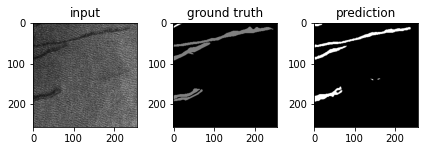

Dice:0.5946 [seep1:0.6804,seep2:0.3847,seep3:0.6522,seep4:0.6845,seep5:0.6464,seep6:0.3608,seep7:0.7531], cross-entropy loss:0.0613


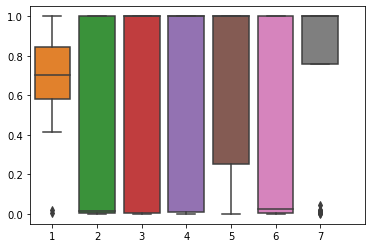

In [ ]:
import seaborn as sns

def dice_multiclass(pred, target):

    smooth = 1.
    dices = []

    for idx in range(1,8):
        iflat = pred.contiguous().view(-1)
        tflat = target.contiguous().view(-1)

        iflat_temp = torch.zeros(iflat.size())
        tflat_temp= torch.zeros(iflat.size())

        iflat_temp[iflat==idx] = 1
        tflat_temp[tflat==idx] = 1

        intersection = (iflat_temp * tflat_temp).sum()

        A_sum = torch.sum(tflat_temp * iflat_temp)
        B_sum = torch.sum(tflat_temp * tflat_temp)

        dice = (2. * intersection + smooth) / (A_sum + B_sum + smooth) 
        dices.append(dice)
    
    return dices

import matplotlib.pyplot as plt 
%matplotlib inline

def evaluation (model, valid_loader, criterion):
    model.eval()
    dice_acc=[]
    sum_loss = 0
    for inputs, actual in valid_loader:
        inputs = inputs.to(device)
        actual = actual.to(device)

        logit = model(inputs)
        pred = logit.argmax(dim=1)
        
        loss = criterion(logit,actual)
        sum_loss += loss.item()
    
        dice_ = dice_multiclass(pred, actual)
        dice_acc.append(dice_) 
    
    ip = inputs[0,0,:,:].detach().cpu().numpy()
    gt = actual[0].detach().cpu().numpy()
    pd = pred[0].detach().cpu().numpy() 
    
    plt.subplot(1,3,1)
    plt.title('input')
    plt.imshow(ip*255, cmap='gray')
    plt.subplot(1,3,2)
    plt.title('ground truth')
    plt.imshow(gt, cmap='gray')
    plt.subplot(1,3,3)
    plt.title('prediction')
    plt.imshow(pd, cmap='gray')
    plt.tight_layout()
    plt.show()

    return np.array(dice_acc), sum_loss/len(valid_loader)

model.load_state_dict(torch.load('/content/drive/MyDrive/segmentation_project_CGG/best_model_linknet.pth'))
dice_acc, final_loss = evaluation (model, valid_loader,criterion)
temp = np.zeros((40,1))
dice_acc_all = np.concatenate((temp,dice_acc),axis=1)
ax = sns.boxplot(data=dice_acc_all)
ax.set_xlim(.5,8)
final_dice = np.mean(dice_acc,0)
print("Dice:%.4f [seep1:%.4f,seep2:%.4f,seep3:%.4f,seep4:%.4f,seep5:%.4f,seep6:%.4f,seep7:%.4f], cross-entropy loss:%.4f" 
      %(np.mean(final_dice), final_dice[0],final_dice[1],final_dice[2],final_dice[3],final_dice[4],
        final_dice[5],final_dice[6],final_loss))

In this project, I use LinkNet to detect non-seep and different classes of seeps. LinkNet is an encoder-decoder segmentation network. The encoder uses ResNet 18 model, and the decoder contains deconvolution, batchnorm and ReLU.<br>
In dataloader, I split the dataset into 20% for validation and remainings are for training. Dataloader contains augmentation of random flipping and pixel normalization into 0-1 range, and the input images are 3 channels. <br>
In the final evaluation, average seep is 0.5946. From the plot we can see, seep-7 is with best prediction among all classes. 